### Filters

In image processing, filtering is an important task which has enormous number of applications. Filtering by default involves the convolution operation which is a necessary step. In this notebook, I discuss about some of the available filters and their implementation. Also, I'll try to explain how a convolutional neural network works. 

### 1. Gaussian filter (blurring)

The gaussian blurring results in a smoothing effect with the help of Gaussian function. 
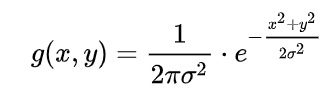
where,
1. sigma is the standard deviation of the filter. 
2. x is the distance from the origin in the horizonal axis. (width)
3. y is the distance from the origin in the vertical axis. (Height)

The above function represents gaussian function in 2-dimension. The graph of this gaussian function is a characteristeic symmetric 'bell curve' shape. This distribution is assumed to have a zero mean. 
> P.S: x & y in the above equation is the dimension of a image. 


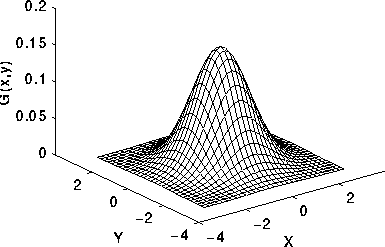
Gaussian distribution with mean (0,0) and standard deviation of 1. 

#### Gaussian filtering
The gaussian filter works by using the above 2-dimensional distribution as a point-spread function (https://en.wikipedia.org/wiki/Point_spread_function). This is usually achieved by convolving the 2-dimnsional gaussian distribution with the original image which results in a blurred image. 

The first step in the convolution process is to get the convolutional kernel. The gaussian function is continious and hence we need to produce a discrete approximation to the gaussian function.
1. Sampled gaussian kernel: Produced by sampling points from the continious gaussian. 
2. An alternate method is to use the discrete gaussian kernel. 

Theretically, this requires an infinitely large kernel, as the distribution is non-zero everywhere, 
In theory, the Gaussian function will be non-zero at every point on an image. In practice, the distribution approaches a very close to zero value at about three standard deviations from the mean. This means we can limit the kernel size to contain values within three standard deviations from the mean. 

The kernel coefficients diminish with increasing distance from the kernel's center.  The central value has the higher weight.

Now that we have the kernel, lets look at the operation. 
Each pixel's value in the original image is set to a weighted average of that pixel's neighborhood. The pixel at computation receives the highest weight and all its neighboring pixels receives lesser weights depending on their distance from the central pixel. The weights are from the convolutional kernel. This process is what is termed as convolution. 

This process results in blurring effect. 
#### Points to note:
1. Changing the value of sigma significantly affects the blurring. Larger the value of sigma, the wider is the peak of gaussian distribution. This means the weights in the sampled kernel dimishes slowly as the distance from the centre increases. 
2. We have to specify the kernel size. This size must increase with increasing sigma to maintain the gaussian nature of the filter. 

#### Resources
1. https://en.wikipedia.org/wiki/Gaussian_filter
2. https://en.wikipedia.org/wiki/Gaussian_blur
3. http://dev.theomader.com/gaussian-kernel-calculator/
4. https://www.cs.auckland.ac.nz/courses/compsci373s1c/PatricesLectures/Gaussian%20Filtering
5. https://homepages.inf.ed.ac.uk/rbf/HIPR2/gsmooth.htm
6. https://en.wikipedia.org/wiki/Point_spread_function
7. https://stackoverflow.com/questions/8204645/implementing-gaussian-blur-how-to-calculate-convolution-matrix-kernel

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import cv2

In [9]:
file = 'illusion.jpg'

In [10]:
image = cv2.imread(file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [11]:
def Res_plot(image, res_image):
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(res_image)

In [12]:
gaussian_blur = cv2.GaussianBlur(image,(5,5),1)

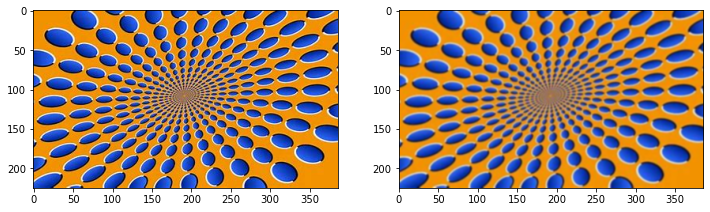

In [13]:
Res_plot(image,gaussian_blur)

In [14]:
# If you want the kernel coefficients you can use this.
kernel = cv2.getGaussianKernel(3,1)      # This returns a vector of coefficients. 

In [15]:
kernel

array([[0.27406862],
       [0.45186276],
       [0.27406862]])

### 2. Averaging

Averaging is a very simple operation where for a pixel, we take the average value of all its neighboring pixels and replace its value by the average. This is achieved by convolving the image with a box kernel. We can use a normalised box filter where each coeffiecients(coefficients are 1 in this case) are divided by the sum of all coefficients. If normalised box filter is not used, the operation may affect the brightness of the image. 

The kernel is defined as, 
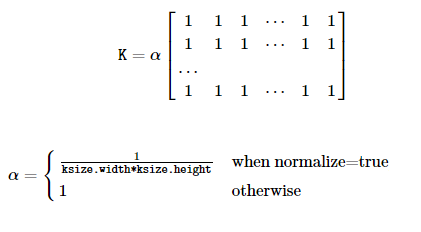

In [16]:
box_blur = cv2.boxFilter(image,cv2.CV_8U,(7,7))

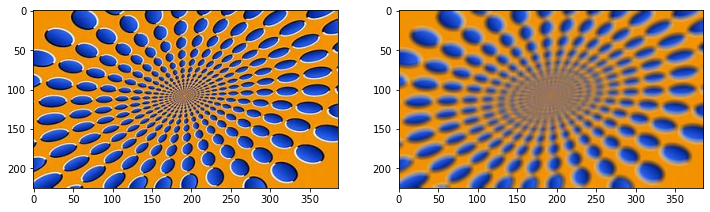

In [17]:
Res_plot(image,box_blur)

### 3. Median filtering

The median filtering function computes the median of all the pixels around the pixel at computation and its value replaced with this median value. The number of pixels to calculate the median depends on the kernel size that we specify.
(For a kernel, with the original pixel at centre, we take the median for all the pixels under that kernel.) 

This is highly effective in removing salt-and-pepper noise. But why?
Salt-and-pepper noise are sparsely occurring white and black pixels in images. Therfore, while taking the median their values exist at the extreme corners. The median value will be different and the original noise value will be replaced by this median value.

In median filtering, unlike gaussian and box filters where the pixel value is replaced by a new one, the replaced median value is actually some pixel value in the original image. 

In [38]:
# To add salt and pepper noise
def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

In [41]:
noise_image = sp_noise(image,0.05)

In [42]:
median_filter = cv2.medianBlur(noise_image,5)

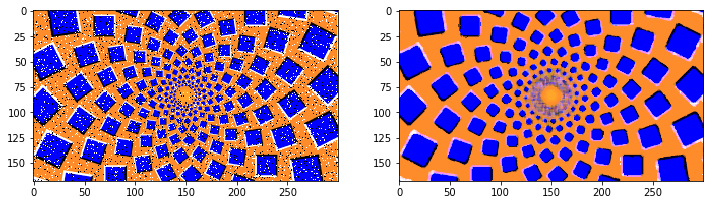

In [77]:
Res_plot(noise_image,median_filter)

### 4. Bilateral filtering

The filters discussed so far tends to blur the edges as well. Bacause, during the filtering process it takes all the pixels under the kernel for computation. It doesn't matter whether the pixels are close to the same intensity value as the pixel at computation or the difference between them and the original pixel is more indicating edges. 

This is not the case for the bilateral filter. Preserving edges is necessary for many applications. Here, the weights depend not only on Euclidean distance of pixels, but also on the radiometric differences (e.g., range differences, such as color intensity, depth distance, etc.). This preserves sharp edges.

The bilateral filter uses another Gaussian filter component which is a function of pixel intensity differences. This ensures that only those pixels with intensities similar to that of the central pixel (‘intensity neighbors’) are included to compute the blurred intensity value. 

For a pixel lying near the edge, the bilateral filter may assign weights appropriately for all its neighboring pixels except for those pixels which exists on the other side of the edge. It may assign very negligeble value of weights (very close to zero) to these pixels since the difference in intensity of these pixels with respect to the original pixel is more. As a result, these pixels are not included for blurring.  

In [69]:
image_texture = cv2.imread('texture-samples.jpeg')
image_texture = cv2.cvtColor(image_texture,cv2.COLOR_BGR2RGB)

In [79]:
bilateral_filter = cv2.bilateralFilter(image_texture,5,95,95)

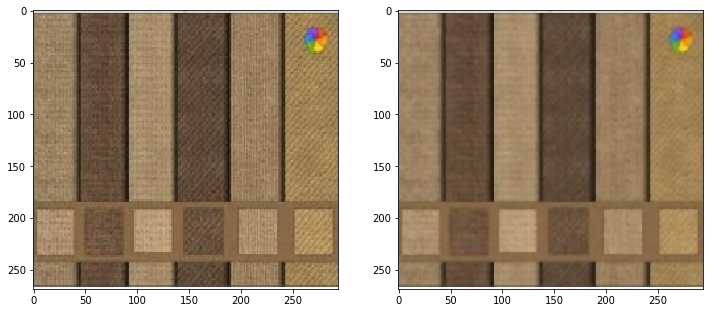

In [80]:
Res_plot(image_texture,bilateral_filter)

Other than the low-pass filters discussed so far, we also have gradient or high pass filters to find gradients/edges in images. These include,
1. Laplacian filter   
2. Sobel filter 
3. Scharr filter

In these filters, we use a kernel with different coefficient values. Similar to the process discussed, in each case the resulting image is obtained by convolving the kernel with the original image. 

#### Resources 
1. https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html 
2. https://docs.opencv.org/master/d5/d0f/tutorial_py_gradients.html
3. https://docs.opencv.org/3.4/d2/d2c/tutorial_sobel_derivatives.html
4. https://docs.opencv.org/3.4/d5/db5/tutorial_laplace_operator.html

In [33]:
kernel_2 = np.array([[0,1,0],[1,0,1],[0,1,0]]).astype('float32')

In [34]:
kernel_2

array([[0., 1., 0.],
       [1., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [35]:
img = cv2.filter2D(image,-1,kernel_2)

In [36]:
image_1 = image

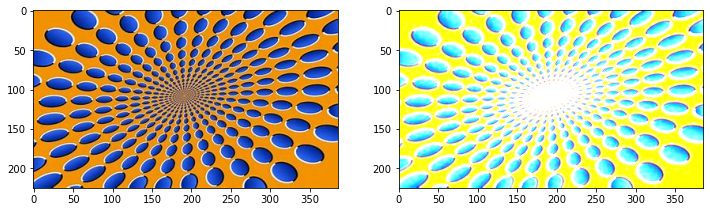

In [37]:
Res_plot(image,img)